<a href="https://colab.research.google.com/github/chit1988/Birth_Rate/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import warnings
warnings.simplefilter(action ="ignore")
warnings.filterwarnings("ignore")

from collections import Counter

# Import the necessary packages
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support


In [41]:
# import google drive

from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
df=pd.read_csv('/content/drive/MyDrive/Maternal Health Risk Data Set.csv')

In [43]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [45]:
print(f"The dataset size: {df.shape}")

The dataset size: (1014, 7)


In [46]:
print(df["RiskLevel"].value_counts())

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


In [47]:
df.tail()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk
1013,32,120,65,6.0,101.0,76,mid risk


In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


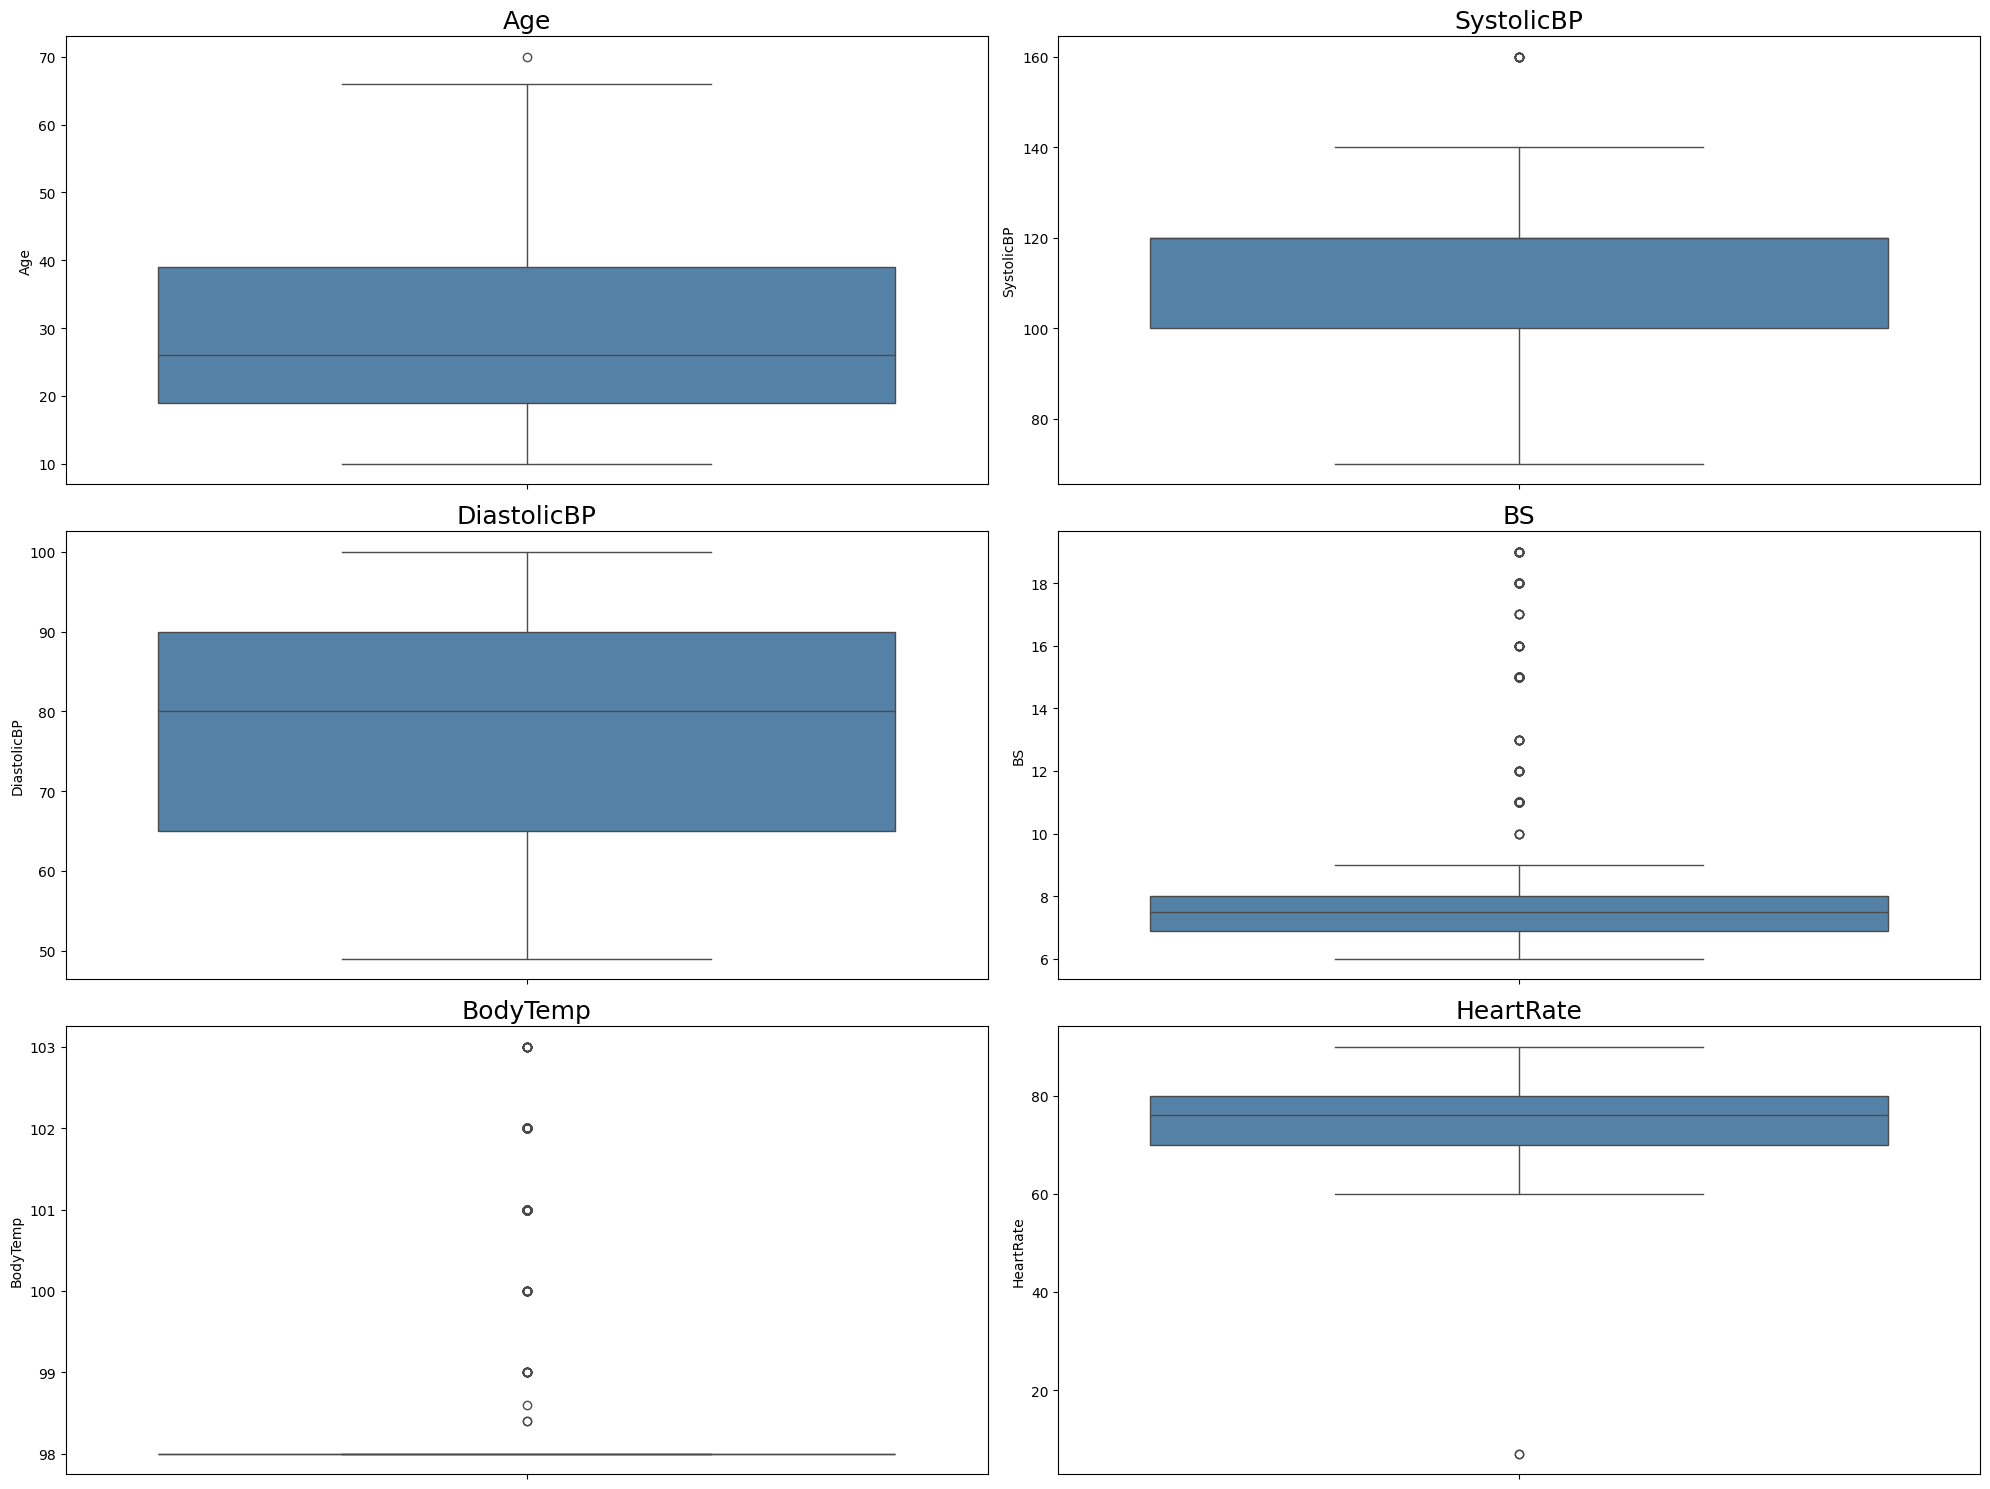

In [49]:
# Plot boxplots for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

for ax, column in zip(axes.flatten(), df.columns):
    sns.boxplot(y=df[column],
                color="#4682B4",
                ax=ax)
    ax.set_title(f"{column}", fontsize=18)

plt.tight_layout()
plt.savefig("materanl_skewed_distribution_to_check_outliars.png")
plt.show()

Correlation Analysis of **Variables**



In [50]:
# Map RiskLevel to integer values
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
df["RiskLevel"] = df["RiskLevel"].map(risk_mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


In [53]:
df['Age'].agg(['min', 'max'])

,Age
min,10
max,70


In [54]:
# make a agegroup 0 to 25 ' young' and 25 to 40 'middel age' and 40 to 60 'early old ' and above 60 'old'
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 25, 40, 60, 100], labels=['young', 'middel age', 'early old', 'old'])
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,AgeGroup
0,25,130,80,15.0,98.0,86,2,young
1,35,140,90,13.0,98.0,70,2,middel age
2,29,90,70,8.0,100.0,80,2,middel age
3,30,140,85,7.0,98.0,70,2,middel age
4,35,120,60,6.1,98.0,76,0,middel age


In [55]:
# make a lable encoding of agegroup column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['AgeGroup'] = le.fit_transform(df['AgeGroup'])
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,AgeGroup
0,25,130,80,15.0,98.0,86,2,3
1,35,140,90,13.0,98.0,70,2,1
2,29,90,70,8.0,100.0,80,2,1
3,30,140,85,7.0,98.0,70,2,1
4,35,120,60,6.1,98.0,76,0,1


In [56]:
# # do the one hot code of agegroup
# df = pd.get_dummies(df, columns=['AgeGroup'])
# df.head()

In [57]:
# # do the lable encoding of agegroup
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df['AgeGroup'] = le.fit_transform(df['AgeGroup'])
# df.head()

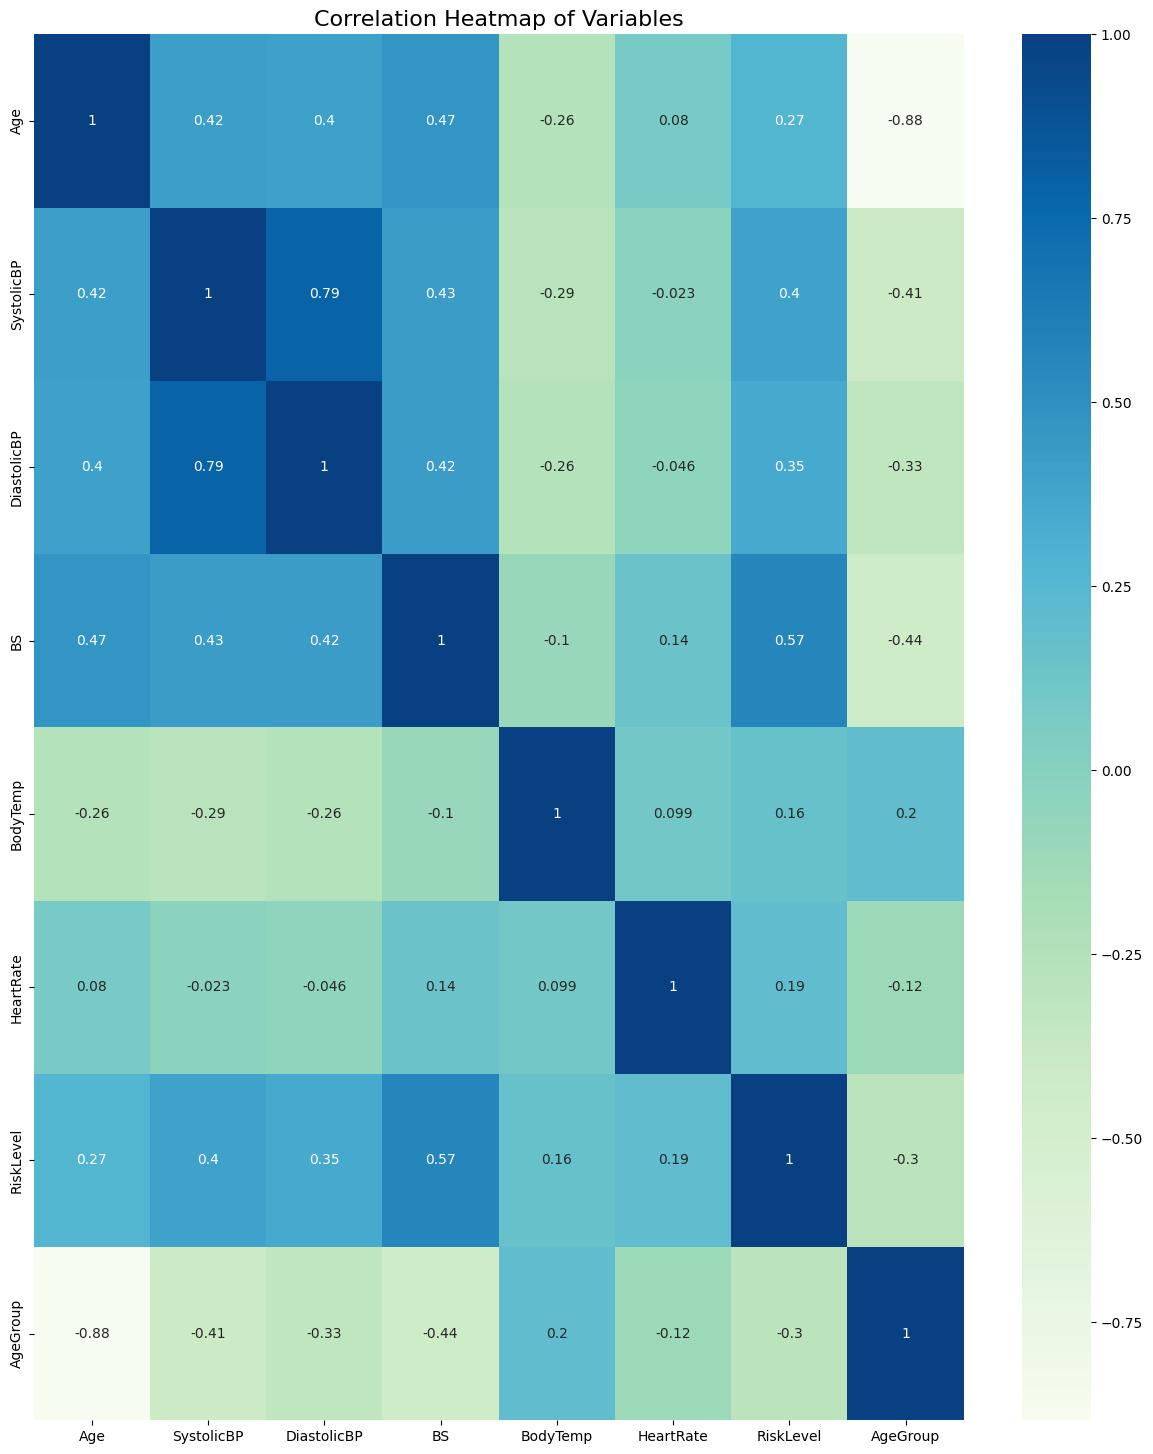

In [59]:
# Create a correlation heatmap
plt.figure(figsize=(15,18))
sns.heatmap(df.corr(), annot=True, cmap = "GnBu")
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.savefig("maternal_heat_map_to_check_correlation.png")
plt.show()

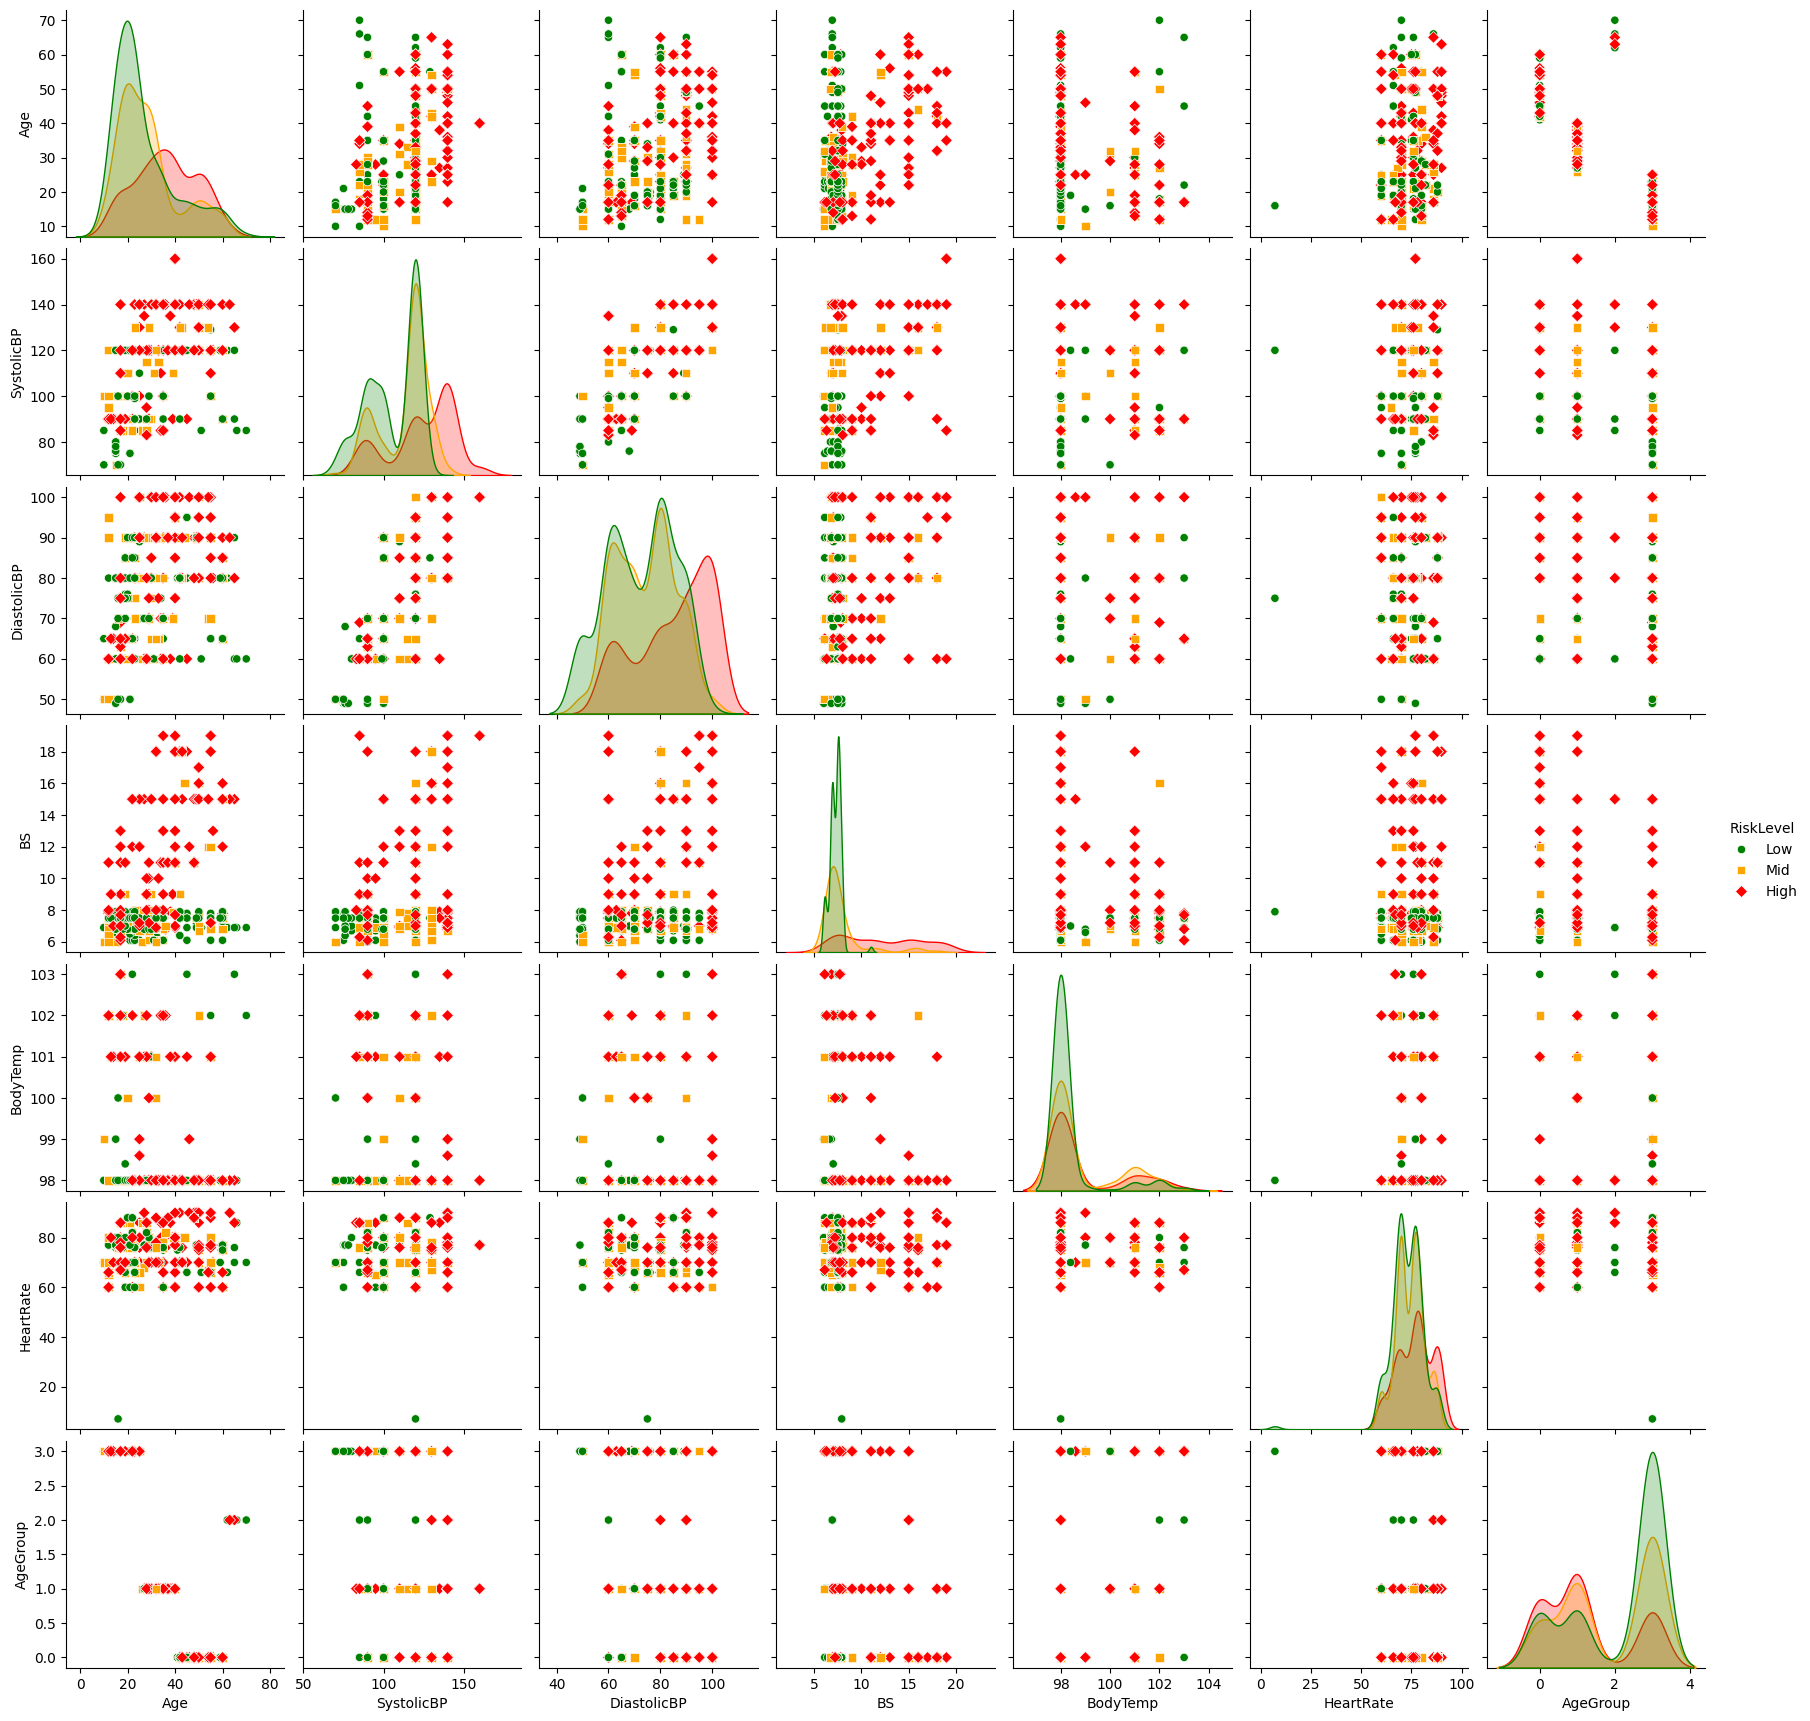

In [61]:
# Create a pairplot with RiskLevel
risk_colors = {0: "green", 1: "orange", 2: "red"}

plot = sns.pairplot(df, hue='RiskLevel',
                    palette=risk_colors,
                    markers=["o", "s", "D"])

legend_labels = {"0": "Low", "1": "Mid", "2": "High"}
for text, label in zip(plot._legend.texts, legend_labels.values()):
    text.set_text(label)
plt.savefig("maternal_pairplot_to_see_patterns.png")
plt.show()

In [63]:
# Dealing with multicollinearity
# Variance Inflation Factor (VIF) calculation
X = df[["SystolicBP", "DiastolicBP"]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,SystolicBP,79.96833
1,DiastolicBP,79.96833


In [65]:
# Drop SystolicBP for model training
df = df.drop(["SystolicBP"], axis=1)

In [66]:
# Identify the outlier in HeartRate
df.HeartRate.sort_values().head()

,HeartRate
908,7
499,7
702,60
783,60
784,60


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   DiastolicBP  1014 non-null   int64  
 2   BS           1014 non-null   float64
 3   BodyTemp     1014 non-null   float64
 4   HeartRate    1014 non-null   int64  
 5   RiskLevel    1014 non-null   int64  
 6   AgeGroup     1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


**Model Building**

In [69]:
# Feature scaling
columns = ["Age", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
scale_X = StandardScaler()
X = pd.DataFrame(scale_X.fit_transform(df.drop(["RiskLevel"],axis = 1),), columns = columns)
y = df["RiskLevel"]

ValueError: Shape of passed values is (1014, 6), indices imply (1014, 5)

In [70]:
# Feature scaling
# Include 'AgeGroup' in the list of columns
columns = ["Age", "DiastolicBP", "BS", "BodyTemp", "HeartRate", "AgeGroup"]
scale_X = StandardScaler()
X = pd.DataFrame(scale_X.fit_transform(df.drop(["RiskLevel"],axis = 1),), columns = columns)
y = df["RiskLevel"]

In [71]:
X.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate,AgeGroup
0,-0.361738,0.255023,1.905890,-0.485215,1.446956,0.957739
1,0.380777,0.975539,1.298340,-0.485215,-0.532088,-0.640858
2,-0.064732,-0.465493,-0.220537,0.973884,0.704815,-0.640858
3,0.009519,0.615281,-0.524312,-0.485215,-0.532088,-0.640858
4,0.380777,-1.186009,-0.797710,-0.485215,0.210054,-0.640858


In [72]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((811, 6), (203, 6), (811,), (203,))

Logistic Regression




In [73]:
# Baseline model of Logistic Regression
logistic_regression = linear_model.LogisticRegression()
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
print(f"Baseline Logistic Regression: {round(logistic_regression_mod.score(X_test, y_test), 3)}")
pred_logistic_regression = logistic_regression_mod.predict(X_test)

Baseline Logistic Regression: 0.631


In [74]:
# Cross validate Logistic Regression model
scores_Logistic = cross_val_score(logistic_regression, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for Logistic Regression model:\n{scores_Logistic}")
print(f"CrossValMeans: {round(scores_Logistic.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_Logistic.std(), 3)}")

Scores(Cross validate) for Logistic Regression model:
[0.54612546 0.56296296 0.59259259]
CrossValMeans: 0.567
CrossValStandard Deviation: 0.019


In [75]:
params_LR = {"tol": [0.0001,0.0002,0.0003],
            "C": [0.01, 0.1, 1, 10, 100],
            "intercept_scaling": [1, 2, 3, 4],
            "solver": ["liblinear", "lbfgs", "newton-cg"],
            "max_iter": [100, 200, 300],
              }

In [78]:
GridSearchCV_LR = GridSearchCV(estimator=linear_model.LogisticRegression(),
                                param_grid=params_LR,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True,
                                )

In [79]:
GridSearchCV_LR.fit(X_train, y_train);

In [80]:
print(f"Best estimator for LR model:\n{GridSearchCV_LR.best_estimator_}")
print(f"Best parameter values for LR model:\n{GridSearchCV_LR.best_params_}")
print(f"Best score for LR model: {round(GridSearchCV_LR.best_score_, 3)}")

Best estimator for LR model:
LogisticRegression(C=0.01, intercept_scaling=3, solver='liblinear')
Best parameter values for LR model:
{'C': 0.01, 'intercept_scaling': 3, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Best score for LR model: 0.599


In [81]:
# Test with new parameter
logistic_regression = linear_model.LogisticRegression(C=0.01, intercept_scaling=1, max_iter=100, solver="liblinear", tol=0.0001, random_state=42)
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
pred_logistic_regression = logistic_regression_mod.predict(X_test)

mse_logistic_regression = mean_squared_error(y_test, pred_logistic_regression)
rmse_logistic_regression = np.sqrt(mean_squared_error(y_test, pred_logistic_regression))
score_logistic_regression_train = logistic_regression_mod.score(X_train, y_train)
score_logistic_regression_test = logistic_regression_mod.score(X_test, y_test)

In [82]:
print(f"Mean Square Error for Logistic Regression = {round(mse_logistic_regression, 3)}")
print(f"Root Mean Square Error for Logistic Regression = {round(rmse_logistic_regression, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_logistic_regression_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_logistic_regression_test, 3)}")

Mean Square Error for Logistic Regression = 0.483
Root Mean Square Error for Logistic Regression = 0.695
R^2(coefficient of determination) on training set = 0.604
R^2(coefficient of determination) on testing set = 0.635


In [84]:
print("Classification Report")
print(classification_report(y_test, pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_logistic_regression))

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.86      0.70        81
           1       0.52      0.21      0.30        67
           2       0.78      0.82      0.80        55

    accuracy                           0.64       203
   macro avg       0.63      0.63      0.60       203
weighted avg       0.62      0.64      0.59       203

Confusion Matrix:
[[70  8  3]
 [43 14 10]
 [ 5  5 45]]


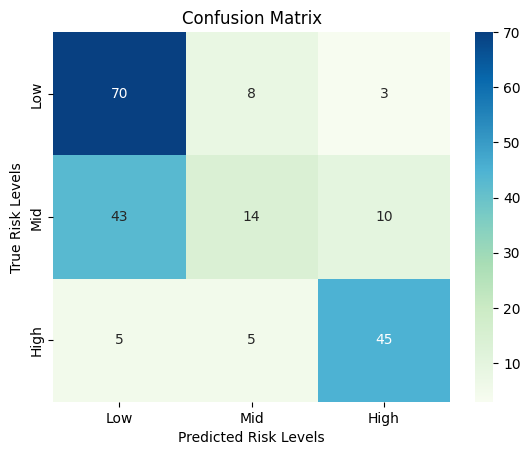

In [85]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_logistic_regression), annot=True, ax=ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

K-Nearest Neighbors

In [86]:
# Baseline model of K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_mod = knn.fit(X_train, y_train)
print(f"Baseline K-Nearest Neighbors: {round(knn_mod.score(X_test, y_test), 3)}")
pred_knn = knn_mod.predict(X_test)

Baseline K-Nearest Neighbors: 0.695


In [87]:
# Cross validate K-Nearest Neighbors model
scores_knn = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for K-Nearest Neighbors model:\n{scores_knn}")
print(f"CrossValMeans: {round(scores_knn.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_knn.std(), 3)}")

Scores(Cross validate) for K-Nearest Neighbors model:
[0.60516605 0.65925926 0.66666667]
CrossValMeans: 0.644
CrossValStandard Deviation: 0.027


In [88]:
params_knn = {"leaf_size": list(range(1,30)),
              "n_neighbors": list(range(1,21)),
              "p": [1,2],
              "weights": ["uniform", "distance"],
             }

In [89]:
GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                                param_grid=params_knn,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [91]:
# Fit model with train data
GridSearchCV_knn.fit(X_train, y_train);

In [92]:
print(f"Best estimator for KNN model:\n{GridSearchCV_knn.best_estimator_}")
print(f"Best parameter values:\n{GridSearchCV_knn.best_params_}")
print(f"Best score for GNB model: {round(GridSearchCV_knn.best_score_, 3)}")

Best estimator for KNN model:
KNeighborsClassifier(leaf_size=5, weights='distance')
Best parameter values:
{'leaf_size': 5, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best score for GNB model: 0.755


In [93]:
# Test with new parameter
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights="distance")
knn_mod = knn.fit(X_train, y_train)
pred_knn = knn_mod.predict(X_test)

mse_knn = mean_squared_error(y_test, pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, pred_knn))
score_knn_train = knn_mod.score(X_train, y_train)
score_knn_test = knn_mod.score(X_test, y_test)

In [94]:
print(f"Mean Square Error for K_Nearest Neighbor  = {round(mse_knn, 3)}")
print(f"Root Mean Square Error for K_Nearest Neighbor = {round(rmse_knn, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_knn_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_knn_test, 3)}")

Mean Square Error for K_Nearest Neighbor  = 0.241
Root Mean Square Error for K_Nearest Neighbor = 0.491
R^2(coefficient of determination) on training set = 0.931
R^2(coefficient of determination) on testing set = 0.833


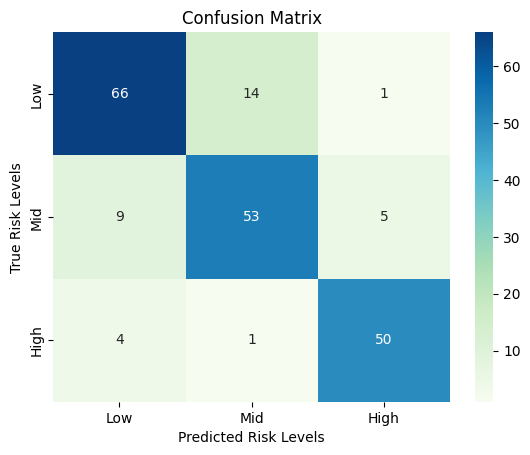

In [95]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

**Random Forest**

In [96]:
# Baseline model of Random Forest Classifier
random_forest = RandomForestClassifier()
random_forest_mod = random_forest.fit(X_train, y_train)
print(f"Baseline Random Forest: {round(random_forest_mod.score(X_test, y_test), 3)}")
pred_random_forest = random_forest_mod.predict(X_test)

Baseline Random Forest: 0.847


In [97]:
# Cross validate Random Forest Classifier model
scores_RF = cross_val_score(random_forest, X_train, y_train, cv=3, scoring = "accuracy")
print(f"Scores(Cross validate) for Random forest model:\n{scores_RF}")
print(f"CrossValMeans: {round(scores_RF.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_RF.std(), 3)}")

Scores(Cross validate) for Random forest model:
[0.74169742 0.78148148 0.81111111]
CrossValMeans: 0.778
CrossValStandard Deviation: 0.028


In [98]:
params_RF = {"min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 2, 4],
              "n_estimators" :[50,100,200,300,400],
              "max_depth": [None, 10, 20, 30],
              "criterion": ["gini", "entropy"]
              }

In [99]:
GridSearchCV_RF = GridSearchCV(estimator=RandomForestClassifier(),
                                param_grid=params_RF,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [100]:
GridSearchCV_RF.fit(X_train, y_train);

In [101]:
print(f"Best estimator for RF model:\n{GridSearchCV_RF.best_estimator_}")
print(f"Best parameter values for RF model:\n{GridSearchCV_RF.best_params_}")
print(f"Best score for RF model: {round(GridSearchCV_RF.best_score_, 3)}")

Best estimator for RF model:
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=400)
Best parameter values for RF model:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best score for RF model: 0.789


In [102]:
# Test with new parameter
random_forest = RandomForestClassifier(criterion="entropy", max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
random_forest_mod = random_forest.fit(X_train, y_train)
pred_random_forest = random_forest_mod.predict(X_test)

mse_random_forest = mean_squared_error(y_test, pred_random_forest)
rmse_random_forest = np.sqrt(mean_squared_error(y_test, pred_random_forest))
score_random_forest_train = random_forest_mod.score(X_train, y_train)
score_random_forest_test = random_forest_mod.score(X_test, y_test)

In [103]:
print(f"Mean Square Error for Random Forest = {round(mse_random_forest, 3)}")
print(f"Root Mean Square Error for Random Forest = {round(rmse_random_forest, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_random_forest_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_random_forest_test, 3)}")

Mean Square Error for Random Forest = 0.207
Root Mean Square Error for Random Forest = 0.455
R^2(coefficient of determination) on training set = 0.931
R^2(coefficient of determination) on testing set = 0.852


In [104]:
print("Classification Report")
print(classification_report(y_test, pred_random_forest))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_random_forest))

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        81
           1       0.82      0.79      0.80        67
           2       0.88      0.96      0.92        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203

Confusion Matrix:
[[67 12  2]
 [ 9 53  5]
 [ 2  0 53]]


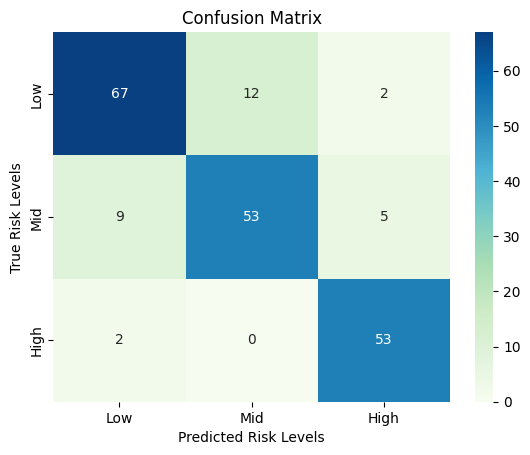

In [105]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_random_forest), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

In [120]:
# Create a DataFrame to store model evaluation results
results = pd.DataFrame({
    "Model": ["Logistic Regression", "K-Nearest Neighbors", "Random Forest", ],
    "Train Score": [
        # Calculate mean cross-validated accuracy for training set
        cross_val_score(logistic_regression_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(knn_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(random_forest_mod, X_train, y_train, cv=3).mean(),
    ],
    "Test Score": [
        # Calculate accuracy on the test set
        logistic_regression_mod.score(X_test, y_test),
        knn_mod.score(X_test, y_test),
        random_forest_mod.score(X_test, y_test),

    ]
})

In [122]:
# Additional Metrics (precision, recall, F1 score)
metrics = ["precision", "recall", "f1"]
for metric in metrics:
    results[f"{metric.capitalize()}"] = [
        precision_recall_fscore_support(y_test, model.predict(X_test), average="weighted")[metrics.index(metric)]
        for model in [logistic_regression_mod, knn_mod, random_forest_mod, ]
    ]

result_df = results.sort_values(by="Test Score", ascending=False)
result_df = result_df.set_index("Test Score")
result_df

,Model,Train Score,Precision,Recall,F1
Test Score,,,,,
0.852217,Random Forest,0.779308,0.851187,0.852217,0.851048
0.832512,K-Nearest Neighbors,0.738650,0.832506,0.832512,0.832423
0.635468,Logistic Regression,0.596811,0.618049,0.635468,0.594816


In [123]:
import pickle

In [124]:
pickle.dump(gbc_mod, open('finalized_birth_model.sav', 'wb'))